# Analysis of IMS data for the HT-plume

In [ ]:
Copyright or © or Copr.  Bernard Legras (2022)
under CeCILL-C license "http://www.cecill.info".

bernard.legras@lmd.ipsl.fr

In [2]:
import IMS
from datetime import date, timedelta, datetime
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.axes as maxes
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import numpy as np
import pickle, gzip

## Zonal average as a function of time

In [ ]:
# Generate counters 
day0 = date(2022,1,13)
day1 = date(2022,4,30)
nbd = (day1 - day0).days + 1
meanIMS = {'SA':np.ma.zeros((nbd,720)),'SO2':np.ma.zeros((nbd,720))}
days = []
missing = []
# Read data and perform averages
day = day0
jd = 0
while day <= day1:    
    try:
        dat = IMS.IMS(day)
        dat.read('SA','N')
        dat.read('SA','D')
        dat.read('SO2','N')
        dat.read('SO2','D')       
    except FileNotFoundError:
        print(day,'missing')
        meanIMS['SA'][jd,:] = np.ma.masked
        meanIMS['SO2'][jd,:] = np.ma.masked
        missing.append(True)
    else:
        print(day)
        # Test for excess values and empirical fix (explore that better)
        for var in ['SA_N','SA_D']:
            aa = np.ma.where(dat.var[var]>10)
            if len(aa[0])>0:
                print(var,len(aa[0]))
                dat.var[var][dat.var[var]>10] = np.ma.masked
        meanIMS['SA'][jd,:] = 0.5*(np.ma.mean(dat.var['SA_N'],axis=1)+np.ma.mean(dat.var['SA_D'],axis=1))
        meanIMS['SO2'][jd,:] = 0.5*(np.ma.mean(dat.var['SO2_N'],axis=1)+np.ma.mean(dat.var['SO2_D'],axis=1))
        missing.append(False)
        
    days.append(day)
    day += timedelta(days=1)
    jd += 1
    
with gzip.open('meanIMS.pkl','wb') as f:
    pickle.dump(meanIMS,f,protocol=5)

In [7]:
# load the result
with gzip.open('meanIMS.pkl','rb') as f:
    meanIMS = pickle.load(f)

## Plots for figure 4

Latitude boundaries and time scale

In [8]:
lats_edge = np.arange(dat.attr['la0'],dat.attr['la1']+0.5*dat.attr['dla'],dat.attr['dla'])
jy0 = np.where(lats_edge > -35)[0][0]
jy1 = np.where(lats_edge > 20)[0][0]
lat0 = dat.attr['la0'] + jy0*dat.attr['dla']
lat1 = dat.attr['la0'] + jy1*dat.attr['dla']
xlims = mdates.date2num([days[0],days[-1]])
date_format = mdates.DateFormatter('%b-%d')

Plot of the mean SA and SO2

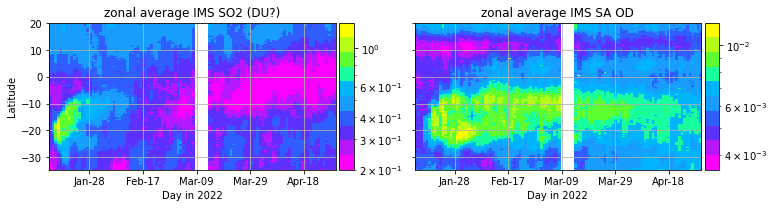

In [9]:
fig, [ax0,ax1] = plt.subplots(nrows=1,ncols=2,figsize=(12,3),sharey=True)
im0 = ax0.imshow(meanIMS['SO2'][:,jy0:jy1].T,aspect=1,cmap=IMS.cmap2,origin='lower',interpolation='nearest',
                       norm=colors.LogNorm(vmin=0.2,vmax=1.4),extent=(xlims[0],xlims[-1],lat0,lat1))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.xaxis.set_major_formatter(date_format)
im1 = ax1.imshow(meanIMS['SA'][:,jy0:jy1].T,aspect=1,cmap=IMS.cmap2,origin='lower',interpolation='nearest',
                       norm=colors.LogNorm(vmin=None,vmax=None),extent=(xlims[0],xlims[-1],lat0,lat1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.xaxis.set_major_formatter(date_format)
ax0.set_ylabel('Latitude')
ax0.set_title('zonal average IMS SO2 (DU?)')
ax1.set_title('zonal average IMS SA OD')
ax0.set_xlabel('Day in 2022')
ax1.set_xlabel('Day in 2022')
ax0.grid(True)
ax1.grid(True)
#plt.savefig('zonalIMS.png',dpi=144,bbox_inches='tight')
plt.show()

In [ ]:
column_CALIOP.shape
xx = mdates.date2num(attribs['days'])
apr30 = np.where(xx == mdates.date2num(date(2022,4,30)))[0][0]
column_CALIOP.shape
attribs['days'][93]

Same figure as a second row of a composite where the first row is made with plots from SA and SO2 for 20 January plus room for Hima image same day at related hour
This is figure 4 of the HT plume paper
ACHTUNG ACHTUNG: this figure fails to be produced with correct layout on Windows 
This seems to be a problem with constrained_layout

<Figure size 1224x410.4 with 0 Axes>

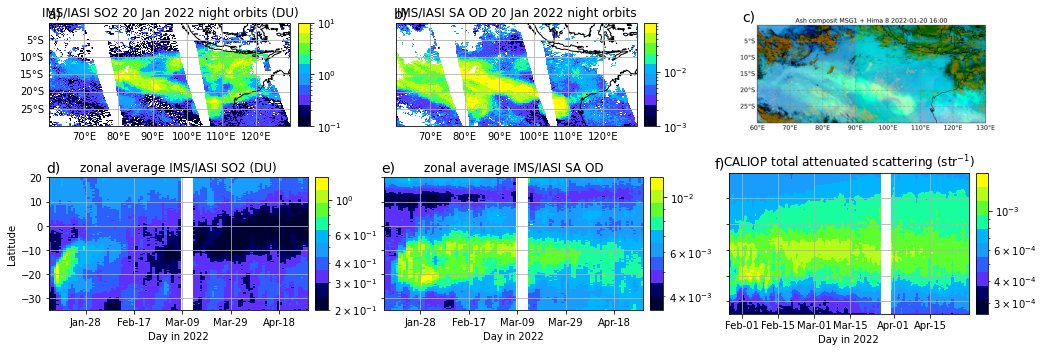

In [13]:
fig = plt.figure(constrained_layout=True,figsize=(17,5.7))
fig = plt.figure(figsize=(17,5.7))
gs0 = fig.add_gridspec(2,1)
gs1 = gs0[0].subgridspec(1,5,width_ratios=[10,0.8,10,0.6,10])
# Other method
#gs2 = gs0[1].subgridspec(1,4,width_ratios=[6,1,6,1],wspace=0.0)
gs2 = gs0[1].subgridspec(1,3)
ax0 = fig.add_subplot(gs2[0])
ax1 = fig.add_subplot(gs2[1])
ax3 = fig.add_subplot(gs1[0],projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs1[2],sharey=ax3,projection=ccrs.PlateCarree())

# The two upper IMS panels ax2 and ax3
dat = IMS.IMS(date(2022,1,20))
dat.read('SA','N')
dat.read('SO2','N')
# Conversion factor from ppbv to DU for SO2
ppbv2DU = 0.79
dat.var['SO2_N'] *= ppbv2DU
im2 = dat.show('SA_N',axf=ax2,xlims=(60,130),ylims=(-30,0),cmap=IMS.cmap3,log=True,
               vmin=0.001,vmax=0.08,left=False,
               txt = 'IMS/IASI SA OD 20 Jan 2022 night orbits')
im3 = dat.show('SO2_N',axf=ax3,xlims=(60,130),ylims=(-30,0),cmap=IMS.cmap3,log=True,
               vmin=0.1,vmax=10,txt='IMS/IASI SO2 20 Jan 2022 night orbits (DU)')
divider = make_axes_locatable(ax2)
# higher pad shrinks in width (??)
# the parameter axes_class=maxes.Axes is necessary due to the cartopy projection
cax = divider.append_axes('right', size='5%', pad=0.1,axes_class=maxes.Axes) 
fig.colorbar(im2, cax=cax, orientation='vertical')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.1,axes_class=maxes.Axes) # higher pad shrinks in width (??)
fig.colorbar(im3, cax=cax, orientation='vertical')

# The two lower IMS panels ax0 and ax1
im0 = ax0.imshow(meanIMS['SO2'][:,jy0:jy1].T,aspect=1,cmap=IMS.cmap3,origin='lower',interpolation='nearest',
                       norm=colors.LogNorm(vmin=0.2,vmax=1.4),extent=(xlims[0],xlims[-1],lat0,lat1))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.1) # higher pad shrinks in width (??)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.xaxis.set_major_formatter(date_format)
im1 = ax1.imshow(meanIMS['SA'][:,jy0:jy1].T,aspect=1,cmap=IMS.cmap3,origin='lower',interpolation='nearest',
                       norm=colors.LogNorm(vmin=None,vmax=None),extent=(xlims[0],xlims[-1],lat0,lat1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical',shrink=0.5)
ax1.xaxis.set_major_formatter(date_format)

# Adding the CALIOP plot
with gzip.open(os.path.join('..','HT-OMPS','integrated_CALIOP_OMPS.pkl'),'rb') as f:
    [column_CALIOP,column_MLS,attribs] = pickle.load(f)
xxe = mdates.date2num(attribs['days_edge'])
xx = mdates.date2num(attribs['days'])
lats_edge = attribs['lats_edge']
ax5 = fig.add_subplot(gs2[2])
apr30 = np.where(xx == mdates.date2num(date(2022,4,30)))[0][0]
vmax = 1.4e-3
im5 = ax5.imshow(column_CALIOP[0:apr30+1,:].T,extent=(xx[0],xx[93],attribs['lats'][0],attribs['lats'][-1]),
           cmap=IMS.cmap3,norm=colors.LogNorm(),origin='lower')
#im5 = ax5.pcolormesh(xxe,lats_edge,column_CALIOP.T,cmap=IMS.cmap3,norm=colors.LogNorm())
#ax5.set_xlim(xx[0],mdates.date2num(date(2022,4,30))+0.5)
ax5.xaxis_date()
date_format = mdates.DateFormatter('%b-%d')
ax5.xaxis.set_major_formatter(date_format)
ax5.grid(True)
ax5.set_ylabel('    ')
ax5.set_yticklabels('')
ax5.set_xlabel('Day in 2022')
ax5.set_title(u'CALIOP total attenuated scattering (str$^{-1}$)')
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im5, cax=cax, orientation='vertical',shrink=0.5)

fig.autofmt_xdate()

ax0.set_ylabel('Latitude')
ax1.set_yticklabels('')
ax1.set_ylabel('   ')
ax0.set_title('zonal average IMS/IASI SO2 (DU)')
ax1.set_title('zonal average IMS/IASI SA OD')
ax0.set_xlabel('Day in 2022')
ax1.set_xlabel('Day in 2022')
ax0.grid(True)
ax1.grid(True)

#  Adding the RGSB Ash panel
ax4 = fig.add_subplot(gs1[4])
import matplotlib.image as image
rgb = image.imread(os.path.join('..','HT-GEO','RGB-16h-fig4.png'))
ax4.imshow(rgb,aspect=1)
ax4.axis('off')

ax1.annotate('e)',(-0.01,1.04),xycoords='axes fraction',fontsize=14)
ax0.annotate('d)',(-0.01,1.04),xycoords='axes fraction',fontsize=14)
ax3.annotate('a)',(-0.01,1.05),xycoords='axes fraction',fontsize=14)
ax2.annotate('b)',(-0.01,1.05),xycoords='axes fraction',fontsize=14)
ax5.annotate('f)',(-0.06,1.04),xycoords='axes fraction',fontsize=14)
ax4.annotate('c)',(0.02,0.95),xycoords='axes fraction',fontsize=14)

#plt.savefig('fig4.png',dpi=300,bbox_inches='tight')
plt.show()

## Plots for figure 3

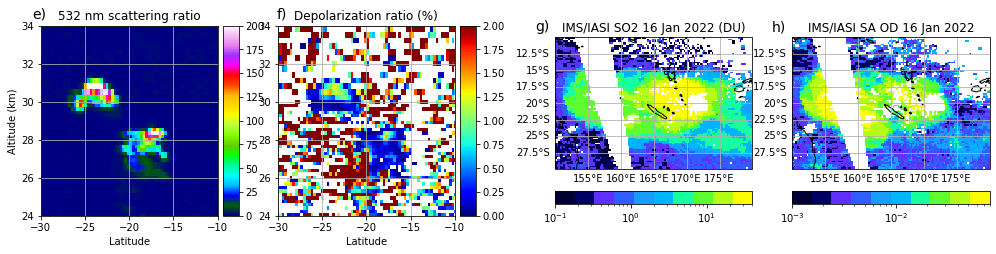

In [14]:
fig = plt.figure(constrained_layout=True,figsize=(17,3.5))
gs = fig.add_gridspec(1,5,width_ratios=[5,5,0.005,5,5],wspace=0.25)
dat = IMS.IMS(date(2022,1,16))
dat.read('SA','N')
dat.read('SO2','N')
# Conversion factor from ppbv to DU for SO2
ppbv2DU = 0.79

#IMS plots
ax3 = fig.add_subplot(gs[3],projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[4],projection=ccrs.PlateCarree())
im2 = dat.show('SA_N',axf=ax2,xlims=(150,180),ylims=(-30,-10),cmap=IMS.cmap3,
               log=True,vmin=0.001,vmax=0.08,aspect=1,txt='IMS/IASI SA OD 16 Jan 2022')
im3 = dat.show('SO2_N',axf=ax3,xlims=(150,180),ylims=(-30,-10),cmap=IMS.cmap3,aspect=1,
               log=True,vmin=0.1,vmax=40,txt='IMS/IASI SO2 16 Jan 2022 (DU)')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('bottom', size='10%', pad=0.3,axes_class=maxes.Axes) 
fig.colorbar(im2, cax=cax, orientation='horizontal')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('bottom', size='10%', pad=0.3,axes_class=maxes.Axes)
fig.colorbar(im3, cax=cax, orientation='horizontal')


with gzip.open(os.path.join('..','HT-HT','superCatal_caliop.0_nit.pkl'),'rb') as f:
    catal = pickle.load(f)
ax0 = fig.add_subplot(gs[0])
latsEdge = catal['attr']['lats_edge']
altsEdge = catal['attr']['alts_edge']
im0=ax0.pcolormesh(latsEdge,altsEdge,catal['data'][24]['SR532'].T,
                   vmin=0,vmax=200,cmap='gist_ncar')
ax0.set_xlim(-30,-10)
ax0.set_ylim(24,34)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='9%',pad=0.07,axes_class=maxes.Axes) 
fig.colorbar(im0, cax=cax, orientation='vertical')
ax1 = fig.add_subplot(gs[1])
im1=ax1.pcolormesh(latsEdge,altsEdge,100*catal['data'][24]['DEPOL'].T,
                   vmin=0,vmax=2,cmap='jet')
ax1.set_xlim(-30,-10)
ax1.set_ylim(24,34)
#ax1.set_yticklabels([])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='9%', pad=0.07,axes_class=maxes.Axes) 
fig.colorbar(im1, cax=cax, orientation='vertical')
ax0.grid(True)
ax1.grid(True)
#ax0.set_aspect(2)
#ax1.set_aspect(2)
ax0.set_ylabel('Altitude (km)')
ax0.set_xlabel('Latitude')
ax1.set_xlabel('Latitude')
ax1.set_title('Depolarization ratio (%)')
ax0.set_title('532 nm scattering ratio')
ax0.annotate('e)',(-0.05,1.04),xycoords='axes fraction',fontsize=14)
ax1.annotate('f)',(-0.01,1.04),xycoords='axes fraction',fontsize=14)
ax2.annotate('h)',(-0.1,1.05),xycoords='axes fraction',fontsize=14)
ax3.annotate('g)',(-0.1,1.05),xycoords='axes fraction',fontsize=14)
#plt.savefig('IMS-CALIOP-fig3.png',dpi=300,bbox_inches='tight')
plt.show()

## Composite des images SA

#### Version 1

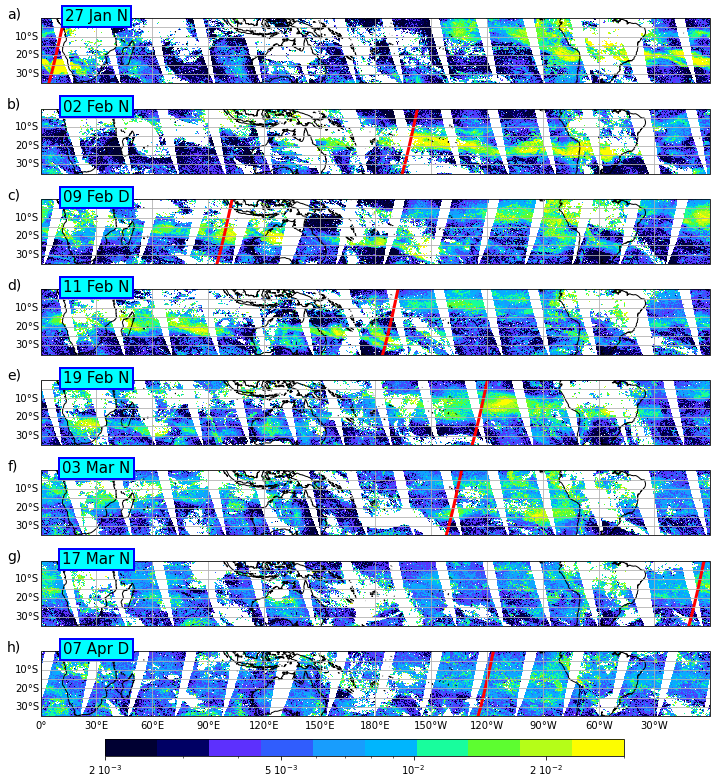

In [7]:
days = [date(2022,1,27),date(2022,2,2),date(2022,2,9),date(2022,2,11),date(2022,2,19),date(2022,3,3),date(2022,3,17),date(2022,4,7)]
ND = ['N','N','D','N','N','N','N','D']
anot = ['a)','b)','c)','d)','e)','f)','g)','h)']
sel = [2,2,2,2,2,2,2,3]
idx = [19,99,220,231,346,522,736,98]
cm = 180

sektions ={}
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.2_nit.pkl'),'rb') as f:
    sektions[2] = pickle.load(f)
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.3_nit.pkl'),'rb') as f:
    sektions[3] = pickle.load(f)

fig, axs = plt.subplots(figsize=(12,12),nrows=8,ncols=1,sharex=True,\
                      subplot_kw={"projection":ccrs.PlateCarree(central_longitude=cm)})
jd = 0
for day in days:
    dat = IMS.IMS(day)
    dat.read('SA',ND[jd])
    dat2 = dat.shift(0)
    if jd == 7: bottom=True
    else: bottom = False
    im = dat2.show('SA_'+ND[jd],axf=axs[jd],txt='',vmin=0.002,vmax=0.03,cmap=IMS.cmap3,log=True,cm=cm,ylims=(-35,0),bottom=bottom)
    axs[jd].annotate(anot[jd],(-0.05,1),xycoords='axes fraction',fontsize=14)
    #axs[jd].annotate('27 Jan',(0.01,0.845),xycoords='axes fraction',fontsize=14,color='red')
    axs[jd].text(-150, 0.845, day.strftime('%d %b ')+ND[jd], ha="center", va="center", size=15,
    bbox=dict(boxstyle="square,pad=0.2", fc="cyan", ec="b", lw=2))
    axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']-cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
    axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']+cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
    axs[jd].set_ylim(-35,0)
    jd += 1
fig.subplots_adjust(bottom=0.06)
cbar_ax = fig.add_axes([0.2,0.02,0.6,0.02])
# colorbar ticks must be set manually here
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks=[2e-3,5e-3,1e-2,2e-2])
cbar.ax.set_xticklabels([u'2 10$^{-3}$',u'5 10$^{-3}$',u'10$^{-2}$',u'2 10$^{-2}$'])
plt.savefig('IMS-fig5.png',dpi=300,bbox_inches='tight')
plt.show()

#### Version 2

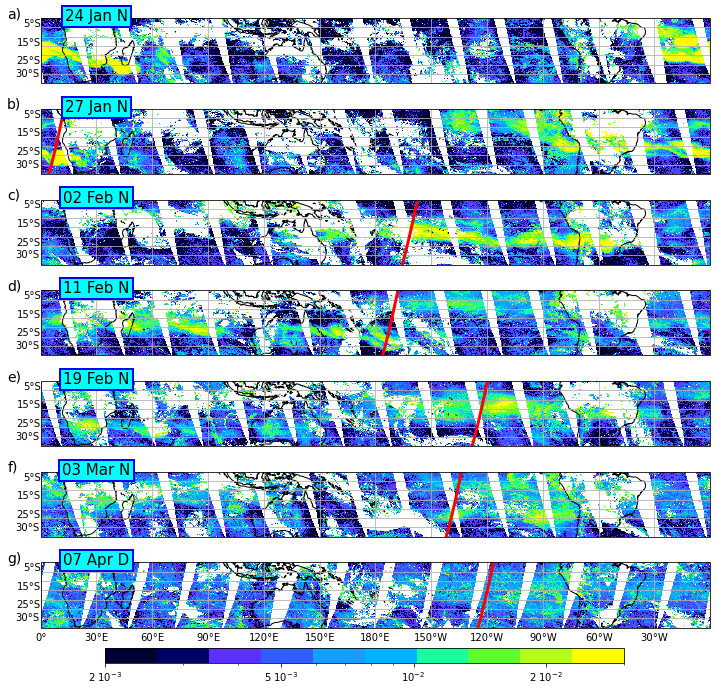

In [8]:
days = [date(2022,1,24),date(2022,1,27),date(2022,2,2),date(2022,2,11),date(2022,2,19),
        date(2022,3,3),date(2022,4,7)]
ND = ['N','N','N','N','N','N','D']
anot = ['a)','b)','c)','d)','e)','f)','g)']
sel = [-1,2,2,2,2,2,3]
idx = [-1,19,99,231,346,522,98]
cm = 180

sektions ={}
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.2_nit.pkl'),'rb') as f:
    sektions[2] = pickle.load(f)
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.3_nit.pkl'),'rb') as f:
    sektions[3] = pickle.load(f)

fig, axs = plt.subplots(figsize=(12,12*7/8),nrows=7,ncols=1,sharex=True,\
                      subplot_kw={"projection":ccrs.PlateCarree(central_longitude=cm)})
jd = 0
for day in days:
    dat = IMS.IMS(day)
    dat.read('SA',ND[jd])
    dat2 = dat.shift(0)
    if jd == 6: bottom=True
    else: bottom = False
    im = dat2.show('SA_'+ND[jd],axf=axs[jd],txt='',vmin=0.002,vmax=0.03,cmap=IMS.cmap3,log=True,cm=cm,
                   ylims=(-35,0),bottom=bottom)
    axs[jd].annotate(anot[jd],(-0.05,1),xycoords='axes fraction',fontsize=14)
    axs[jd].text(-150, 0.845, day.strftime('%d %b ')+ND[jd], ha="center", va="center", size=15,
    bbox=dict(boxstyle="square,pad=0.2", fc="cyan", ec="b", lw=2))
    if sel[jd]>=0:
        axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']-cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
        axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']+cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
    axs[jd].set_ylim(-35,0)
    jd += 1
fig.subplots_adjust(bottom=0.06)
cbar_ax = fig.add_axes([0.2,0.02,0.6,0.02])
# colorbar ticks must be set manually here
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks=[2e-3,5e-3,1e-2,2e-2])
cbar.ax.set_xticklabels([u'2 10$^{-3}$',u'5 10$^{-3}$',u'10$^{-2}$',u'2 10$^{-2}$'])
#plt.savefig('IMS-fig5bis.png',dpi=300,bbox_inches='tight')
plt.show()

#### Version 3

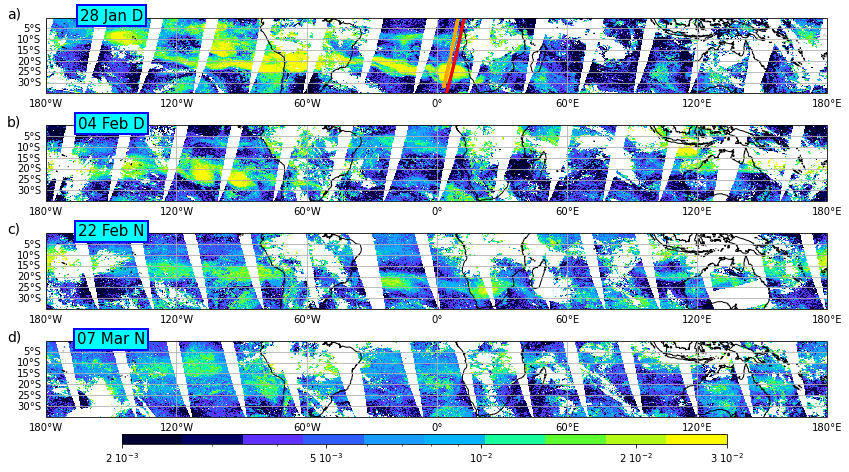

In [169]:
days = [date(2022,1,28),date(2022,2,4),date(2022,2,22),date(2022,3,7)]
ND = ['D','D','N','N']
anot = ['a)','b)','c)','d)','e)','f)','g)']
sel = [2,2,2,2,2,3]
idx = [19,99,231,346,522,98]
cm = 0

sektions ={}
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.2_nit.pkl'),'rb') as f:
    sektions[2] = pickle.load(f)
with gzip.open(os.path.join('..','HT-HT','sektions_caliop.3_nit.pkl'),'rb') as f:
    sektions[3] = pickle.load(f)

fig, axs = plt.subplots(figsize=(14,7),nrows=4,ncols=1,sharex=True,\
                      subplot_kw={"projection":ccrs.PlateCarree(central_longitude=cm)})
jd = 0
for day in days:
    dat = IMS.IMS(day)
    dat.read('SA',ND[jd])
    dat2 = dat
    if jd == 3: bottom=True
    else: bottom = False
    bottom=True
    im = dat2.show('SA_'+ND[jd],axf=axs[jd],txt='',vmin=0.002,vmax=0.03,cmap=IMS.cmap3,log=True,cm=cm,
                   ylims=(-35,0),bottom=bottom)
    axs[jd].annotate(anot[jd],(-0.05,1),xycoords='axes fraction',fontsize=14)
    axs[jd].text(-150, 0.845, day.strftime('%d %b ')+ND[jd], ha="center", va="center", size=15,
    bbox=dict(boxstyle="square,pad=0.2", fc="cyan", ec="b", lw=2))
    if jd == 0:
        axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']-cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
        axs[jd].plot(sektions[sel[jd]]['data'][idx[jd]]['lons']+cm,sektions[sel[jd]]['data'][idx[jd]]['lats'],'r',lw=3)
        axs[jd].plot(lon28,lat28,lw=3,color='orange')
    axs[jd].set_ylim(-35,0)
    jd += 1
fig.subplots_adjust(bottom=0.06)
cbar_ax = fig.add_axes([0.2,0.02,0.6,0.02])
# colorbar ticks must be set manually here
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal',ticks=[2e-3,5e-3,1e-2,2e-2,3e-2])
cbar.ax.set_xticklabels([u'2 10$^{-3}$',u'5 10$^{-3}$',u'10$^{-2}$',u'2 10$^{-2}$',u'3 10$^{-2}$'])
plt.savefig('IMS-fig5ter.png',dpi=300,bbox_inches='tight')
plt.show()

### Extraction des cas intéressants

C:\Users\berna\AppData\Local\Temp\ipykernel_24072\1338650216.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.9)


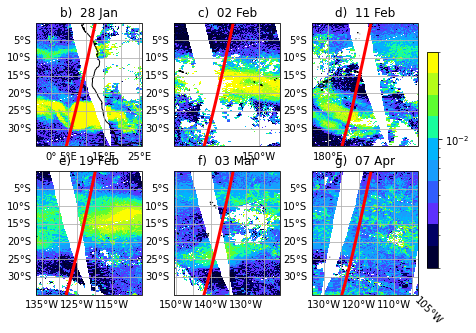

In [9]:
# This needs gridspec instead of subplots as the projections are différents
fig = plt.figure(constrained_layout=True,figsize=(7,5))
gs = fig.add_gridspec(2,3)

axc = []
jy = (0,0,0,1,1,1)
ix = (0,1,2,0,1,2)
jd = 0
for jd in range(6):
    if jd in [1,2] : cm = 180
    else : cm = 0
    axc.append(fig.add_subplot(gs[jy[jd],ix[jd]],
                projection=ccrs.PlateCarree(central_longitude=cm)))
    day = days[jd+1]
    dat = IMS.IMS(day)
    dat.read('SA',ND[jd+1])
    if cm == 0: dat2 = dat
    else: dat2 = dat.shift(0)
    #if jd == 7: bottom=True
    #else: bottom = False
    lon = catal[sel[jd+1]]['data'][idx[jd+1]]['lon']
    if jd in [1,2]: lon = lon%360
    else: 
        if lon > 180: lon -= 360
    im = dat2.show('SA_'+ND[jd+1],axf=axc[jd],txt=' ',vmin=0.002,vmax=0.03,cmap=IMS.cmap3,log=True,cm=cm,
                   ylims=(-35,0),xlims=(lon-15-cm,lon+15-cm),bottom=True)
    axc[jd].set_title(anot[jd+1]+catal[sel[jd+1]]['data'][idx[jd+1]]['date'].strftime('  %d %b'))
    #axc[jd].plot(sektions[sel[jd+1]]['data'][idx[jd+1]]['lons']-cm,sektions[sel[jd+1]]['data'][idx[jd+1]]['lats'],'r',lw=3)
    axc[jd].plot(sektions[sel[jd+1]]['data'][idx[jd+1]]['lons']+cm,sektions[sel[jd+1]]['data'][idx[jd+1]]['lats'],'r',lw=3)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91,0.2,0.02,0.6])
fig.colorbar(im,cax=cbar_ax,orientation='vertical')   
plt.savefig('IMS-fig6bis.png',dpi=300,bbox_inches='tight')

## Composite des images CALIOP

#### Load catal

In [125]:
catal = {}
with gzip.open(os.path.join('..','HT-HT','superCatal_caliop.2_nit.pkl'),'rb') as f:
    catal[2] = pickle.load(f)
with gzip.open(os.path.join('..','HT-HT','superCatal_caliop.3_nit.pkl'),'rb') as f:
    catal[3] = pickle.load(f)

#### Row plot

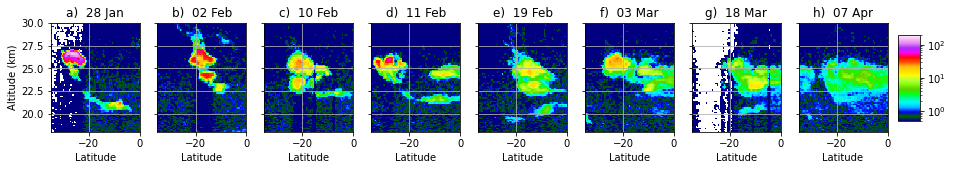

In [78]:
fig, axc = plt.subplots(figsize=(15,2),nrows=1,ncols=8,sharey=True)
latsEdge = catal[2]['attr']['lats_edge']
altsEdge = catal[2]['attr']['alts_edge']

im = {}
for jd in range(8):
    im[jd] = axc[jd].pcolormesh(latsEdge,altsEdge,catal[sel[jd]]['data'][idx[jd]]['SR532'].T,
                                norm=colors.LogNorm(vmin=0.5,vmax=200),cmap='gist_ncar',)
    axc[jd].set_xlim(-35,0)
    axc[jd].set_ylim(18,30)
    axc[jd].grid(True)
    axc[jd].set_title(anot[jd]+catal[sel[jd]]['data'][idx[jd]]['date'].strftime('  %d %b'))
    axc[jd].set_xlabel('Latitude')

axc[0].set_ylabel('Altitude (km)')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91,0.2,0.02,0.6])
fig.colorbar(im[0],cax=cbar_ax,orientation='vertical')   

plt.savefig('CALIOP-fig6.png',dpi=300,bbox_inches='tight')
plt.show()

New caliop plot

10.905957221984863
200.88131713867188
190.36953735351562
238.50869750976562
224.5657958984375
241.68344116210938


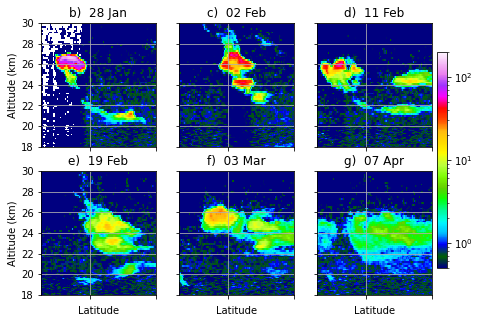

In [62]:
fig, axc = plt.subplots(figsize=(7,5),nrows=2,ncols=3,sharey=True,sharex=True)
axc = axc.flatten()
latsEdge = catal[2]['attr']['lats_edge']
altsEdge = catal[2]['attr']['alts_edge']

im = {}
for jd in range(6):
    print(catal[sel[jd+1]]['data'][idx[jd+1]]['lon'])
    im[jd] = axc[jd].pcolormesh(latsEdge,altsEdge,catal[sel[jd+1]]['data'][idx[jd+1]]['SR532'].T,
                                norm=colors.LogNorm(vmin=0.5,vmax=200),cmap='gist_ncar',)
    axc[jd].set_xlim(-35,0)
    axc[jd].set_ylim(18,30)
    axc[jd].grid(True)
    axc[jd].set_title(anot[jd+1]+catal[sel[jd+1]]['data'][idx[jd+1]]['date'].strftime('  %d %b'))
    if jd > 2: axc[jd].set_xlabel('Latitude')
    #
    else: axc[jd].set_xticklabels('')
axc[0].set_ylabel('Altitude (km)')
axc[3].set_ylabel('Altitude (km)')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91,0.2,0.02,0.6])
fig.colorbar(im[0],cax=cbar_ax,orientation='vertical')   

plt.savefig('IMS-fig6ter.png',dpi=300,bbox_inches='tight')
plt.show()

In [66]:
catal[2]['data'][223].keys()

dict_keys(['missing', 'date', 'lon', 'fname', 'SR532', 'T532', 'TROPOH', 'DEPOL', 'ACR', 'P', 'T', 'INT532'])

## Processing AEOLUS data

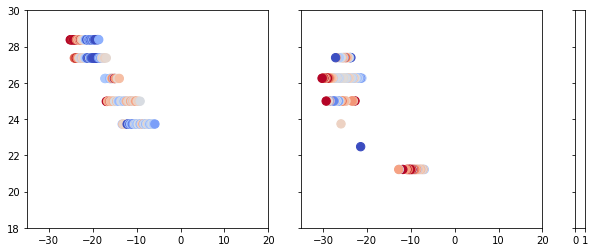

In [47]:
ael = {24:{},28:{}}
ael[24]['nc'] = Dataset(os.path.join('..','Aeolus','Aeolus_orbite_20220124.nc'))
ael[28]['nc'] = Dataset(os.path.join('..','Aeolus','Aeolus_orbite_20220128.nc'))
for day in [24,28]:
    ael[day]['lats'] = ael[day]['nc']['latitude'][:]
    ael[day]['lons'] = ael[day]['nc']['longitude'][:]
    ael[day]['alts'] = ael[day]['nc']['altitude'][:]
    ael[day]['uano'] = ael[day]['nc']['velocity'][:] - ael[day]['nc']['background_velocity'][:]
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw = {'width_ratios':[1,1,0.04]},figsize=(10,  4), sharey=True)
jd=0

for day in [24,28]:
    cc = ax[jd].scatter(ael[day]['lats'], 1.e-3*ael[day]['alts'], c = ael[day]['uano'], cmap = 'coolwarm', vmin=-6., vmax=6., s=70.)
    ax[jd].set_xlim(-35,20)
    ax[jd].set_ylim(18,30)
    jd += 1

Check the lat x lon track for the two cases

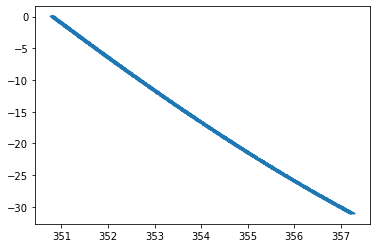

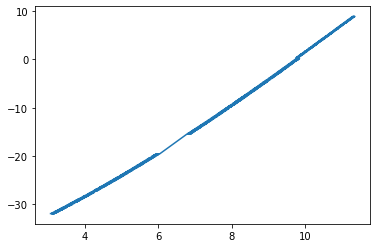

In [186]:
lat24 = ael[24]['lats'][ael[24]['alts']>27]
lon24 = ael[24]['lons'][ael[24]['alts']>27]
plt.plot(lon24,lat24)
plt.show()
lat28 = ael[28]['lats'][ael[28]['alts']>24]
lon28 = ael[28]['lons'][ael[28]['alts']>24]
plt.plot(lon28,lat28)
plt.show()

Get the mean time of the orbit segment
The time is counted in seconds for each day from the start of each orbit

In [230]:
time24 = ael[24]['nc']['time'][:][np.any(ael[24]['alts']>27,axis=1)]
time28 = ael[28]['nc']['time'][:][np.any(ael[28]['alts']>24,axis=1)]
date24 = datetime.strptime((ael[24]['nc'].variables['time'].units)[14:33],'%Y-%m-%dT%H:%M:%S') \
    + timedelta(seconds=np.mean(time24))
date28 = datetime.strptime((ael[28]['nc'].variables['time'].units)[14:33],'%Y-%m-%dT%H:%M:%S') \
    + timedelta(seconds=np.mean(time28))
print('24 Jan',date24,np.mean(lon24))
print('28 Jan',date28,np.mean(lon28))

24 Jan 2022-01-24 18:36:01.845453 353.9217195742574
28 Jan 2022-01-28 05:11:55.184456 7.620815408269441


## New figure 6

C:\Users\berna\AppData\Local\Temp\ipykernel_2288\1466544833.py:147: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('NewFig6.png',dpi=300,bbox_inches='tight')
C:\Users\berna\miniconda3\envs\p39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


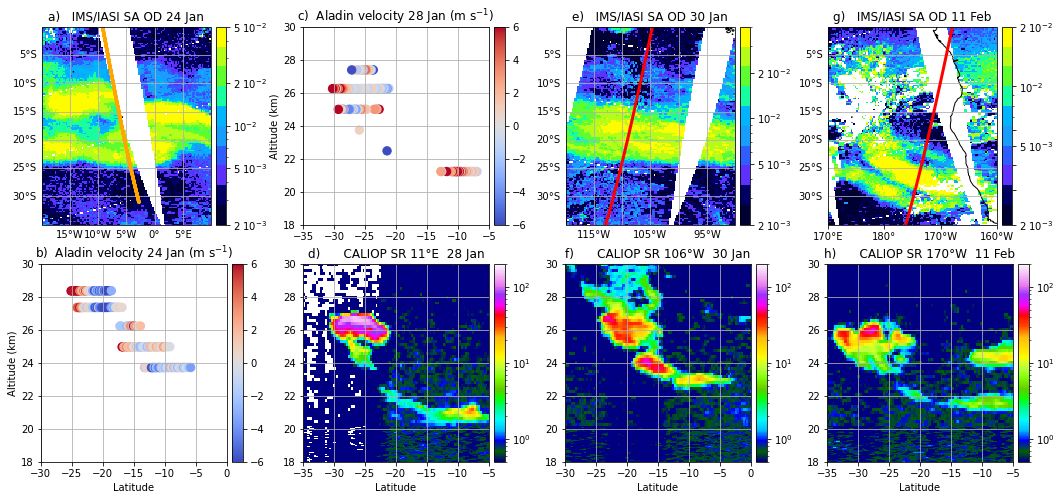

In [232]:
# This needs gridspec instead of subplots as the projections are différents
fig = plt.figure(constrained_layout=True,figsize=(18,8))
gs = fig.add_gridspec(2,4)
latsEdge = catal[2]['attr']['lats_edge']
altsEdge = catal[2]['attr']['alts_edge']

# panel 0 for IMS 24 Jan 
# On this day Aladin orbit at 18:36 by 7°W is close to the night orbit of IASI at 22:52
ax0 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
day = date(2022,1,24)
dat = IMS.IMS(day)
dat.read('SA','N')
im0 = dat.show('SA_N',axf=ax0,txt=' ',vmin=0.002,vmax=0.05,cmap=IMS.cmap3,log=True,cm=0,
                   ylims=(-35,0),xlims=(-20,10),bottom=True)
ax0.plot(lon24-360,lat24,lw=3,color='orange')
ax0.set_title(day.strftime('a)   IMS/IASI SA OD %d %b'))
div0 = make_axes_locatable(ax0)
cax = div0.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
cbar=fig.colorbar(im0, cax=cax, orientation='vertical')
cbar.set_ticks([2e-3,5e-3,1e-2,2e-2,5e-2])
cbar.set_ticklabels([u'2 10$^{-3}$',u'5 10$^{-3}$',u'10$^{-2}$',u'2 10$^{-2}$',u'5 10$^{-2}$'])

# panel 4 for Aladin  24 Jan
ax4 = fig.add_subplot(gs[1,0])
im4 = ax4.scatter(ael[24]['lats'], 1.e-3*ael[24]['alts'], c = ael[24]['uano'], cmap = 'coolwarm', vmin=-6., vmax=6., s=70.)
ax4.set_xlim(-30,0)
ax4.set_ylim(18,30)
ax4.set_xlabel('Latitude')
ax4.set_ylabel('Altitude (km)')
ax4.set_title(day.strftime(u'b)  Aladin velocity %d %b (m s$^{-1}$)'))
ax4.grid(True)
div4 = make_axes_locatable(ax4)
cax = div4.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes)
cbar=fig.colorbar(im4, cax=cax, orientation='vertical')
# Trick to buy some space on the left axis
buf = div4.append_axes('left', size='6%', pad=0.07)
buf.axis('off')

# panel 1 for Aladin  28 Jan
# Aladin orbit at 05:12
# The shown day orbit of IMS on fig.5 is at 08:48
day = date(2022,1,28)
ax1 = fig.add_subplot(gs[0,1])
im1 = ax1.scatter(ael[28]['lats'], 1.e-3*ael[28]['alts'], c = ael[28]['uano'], cmap = 'coolwarm', vmin=-6., vmax=6., s=70.)
ax1.set_ylim(18,30)
ax1.set_xlim(-35,-5)
#ax1.set_xlabel('Latitude')
ax1.set_ylabel('Altitude (km)')
ax1.set_title(day.strftime(u'c)  Aladin velocity %d %b (m s$^{-1}$)'))
ax1.grid(True)
div1 = make_axes_locatable(ax1)
cax = div1.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes)
fig.colorbar(im1, cax=cax, orientation='vertical')
# Trick to buy some space on the left axis
buf = div1.append_axes('left', size='6%', pad=0.07)
buf.axis('off')

# panel 5 for Caliop 28 Jan
# CALIOP orbit (19) at 01:48
ax5 =  fig.add_subplot(gs[1,1])
im5 = ax5.pcolormesh(latsEdge,altsEdge,catal[2]['data'][19]['SR532'].T,
                                norm=colors.LogNorm(vmin=0.5,vmax=200),cmap='gist_ncar',)
ax5.set_xlim(-35,-5)
ax5.set_ylim(18,30)
ax5.grid(True)
#ax5.set_yticklabels('')
ax5.set_xlabel('Latitude')
ax5.set_title(day.strftime('d)      CALIOP SR 11°E  %d %b'))
div5 = make_axes_locatable(ax5)
cax = div5.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
fig.colorbar(im5, cax=cax, orientation='vertical')
buf = div5.append_axes('left', size='6%', pad=0.07)
buf.axis('off')

# panel 2 for IMS 30 Jan
# This orbit is a day orbit 11:28
ax2 = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
day = date(2022,1,30)
dat = IMS.IMS(day)
dat.read('SA','D')
im2 = dat.show('SA_D',axf=ax2,txt=' ',vmin=0.002,vmax=0.04,cmap=IMS.cmap3,log=True,cm=0,
                   ylims=(-35,0),xlims=(-120,-90),bottom=True)
ax2.plot(sektions[2]['data'][53]['lons'],sektions[2]['data'][53]['lats'],'r',lw=3)
ax2.set_title(day.strftime('e)   IMS/IASI SA OD %d %b'))
div2 = make_axes_locatable(ax2)
cax = div2.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
cbar=fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.set_ticks([2e-3,5e-3,1e-2,2e-2])
cbar.set_ticklabels([u'2 10$^{-3}$',u'5 10$^{-3}$',u'10$^{-2}$',u'2 10$^{-2}$'])

# panel 6 for hairy Caliop 30 Jan
# CALIOP orbit (53) at 09:37 
ax6 =  fig.add_subplot(gs[1,2])
im6 = ax6.pcolormesh(latsEdge,altsEdge,catal[2]['data'][53]['SR532'].T,
                                norm=colors.LogNorm(vmin=0.5,vmax=200),cmap='gist_ncar',)
ax6.set_xlim(-30,0)
ax6.set_ylim(18,30)
ax6.grid(True)
#ax6.set_yticklabels('')
ax6.set_xlabel('Latitude')
ax6.set_title(day.strftime('f)      CALIOP SR 106°W  %d %b'))
div6 = make_axes_locatable(ax6)
cax = div6.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
fig.colorbar(im6, cax=cax, orientation='vertical')
buf = div6.append_axes('left', size='6%', pad=0.07)
buf.axis('off')

# panel 3 for IMS 11 Feb
# This panel is a night orbit at 09:49 
ax3 = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
day = date(2022,2,11)
dat = IMS.IMS(day)
dat.read('SA','N')
dats = dat.shift(0)
im3 = dats.show('SA_N',axf=ax3,txt=' ',vmin=0.002,vmax=0.02,cmap=IMS.cmap3,log=True,cm=180,
                   ylims=(-35,0),xlims=(170-180,200-180),bottom=True,xlocs=())
ax3.plot(sektions[2]['data'][231]['lons']+180,sektions[2]['data'][231]['lats'],'r',lw=3)
#ax0.plot(lon24,lat24,lw=3,color='orange')
ax3.set_title(day.strftime('g)   IMS/IASI SA OD %d %b'))
div3 = make_axes_locatable(ax3)
cax = div3.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
cbar=fig.colorbar(im3, cax=cax, orientation='vertical')
cbar.set_ticks([2e-3,3e-3,4e-3,5e-3,6e-3,1e-2,2e-2])
cbar.set_ticklabels([u'2 10$^{-3}$','','',u'5 10$^{-3}$','',u'10$^{-2}$',u'2 10$^{-2}$'])
# Not nice but works
ax3.set_xticks((-10,0,10,20))
ax3.set_xticklabels(('170°E','180°','170°W','160°W'))

# panel 7 for Caliop 11 Feb
# CALIOP orbit (231) at 13:52
ax7 =  fig.add_subplot(gs[1,3])
im7 = ax7.pcolormesh(latsEdge,altsEdge,catal[2]['data'][231]['SR532'].T,
                                norm=colors.LogNorm(vmin=0.5,vmax=200),cmap='gist_ncar')
ax7.set_xlim(-35,-5)
ax7.set_ylim(18,30)
ax7.grid(True)
#ax7.set_yticklabels('')
ax7.set_xlabel('Latitude')
ax7.set_title(day.strftime('h)      CALIOP SR 170°W  %d %b'))
#ax5.set_title(anot[jd+1]+catal[sel[jd+1]]['data'][idx[jd+1]]['date'].strftime('  %d %b'))
div7 = make_axes_locatable(ax7)
cax = div7.append_axes('right', size='6%', pad=0.07,axes_class=maxes.Axes) 
fig.colorbar(im7, cax=cax, orientation='vertical')
buf = div7.append_axes('left', size='6%', pad=0.07)
buf.axis('off')

plt.savefig('NewFig6.png',dpi=300,bbox_inches='tight')
plt.show()

## Investigation for spurious large values

In [42]:
dat = IMS.IMS(day0)
dat.read('SA','N')
dat.read('SA','D')

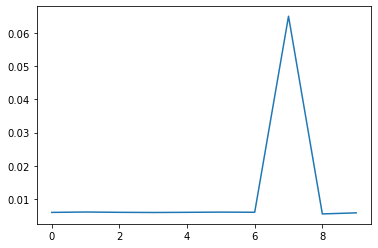

In [46]:
plt.plot(np.ma.mean(dat.var['SA_D'][320:330,:],axis=1))

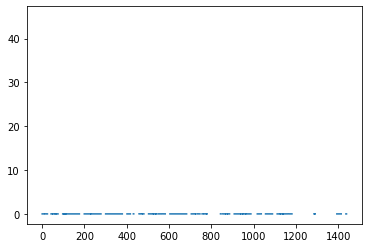

In [47]:
plt.plot(dat.var['SA_D'][327,:])

In [7]:
aa=np.ma.where(dat.var['SA_D']>10)
if len(aa[0])>0:
    print(aa)

(array([327], dtype=int64), array([1369], dtype=int64))


In [51]:
dat.var['SA_D'][301,19]

masked

In [64]:
aa[0]

array([242, 242, 385, 388, 399, 399, 403, 403], dtype=int64)

In [65]:
dat

In [56]:
day0 = date(2022,1,13)
dat = IMS.IMS(day0)
dat.read('SO2','D',close=False)

In [57]:
dat.file.variables['data']

<class 'netCDF4._netCDF4.Variable'>
float32 data(nval, ny, nx)
    long_name: SO2
    units: ppbv
    _FillValue: -999000000000.0
unlimited dimensions: 
current shape = (1, 720, 1440)
filling on

In [6]:
day0 = date(2022,1,13)
dat = IMS.IMS(day0)
dat.read('SA','D',close=False)
dat.file.variables['qa_value']

<class 'netCDF4._netCDF4.Variable'>
int8 qa_value(ny, nx)
    long_name: Quality control value used to screen values for plotting; 0=do not plot; _Fillvalue means mask is not defined so the mask is not used (data will be plotted); other values to be interpretted by nrt_plot_ql
    _FillValue: -1
unlimited dimensions: 
current shape = (720, 1440)
filling on

In [8]:
qa = dat.file.variables['qa_value'][:]

In [11]:
qa[327,1360:1380]

masked_array(data=[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
                   0, 0],
             mask=False,
       fill_value=999999,
            dtype=int8)

In [17]:
dat.var['SA_D'].data[327,1360:1380]

array([-9.98999982e+11,  1.00934446e-01,  1.13581670e-02,  2.30701081e-02,
        1.03492811e-02,  1.11051220e-02, -9.98999982e+11, -9.98999982e+11,
        5.74059248e-01,  4.50884857e+01, -9.98999982e+11, -9.98999982e+11,
       -9.98999982e+11,  1.79101396e-02, -9.98999982e+11,  6.53123762e-03,
       -9.98999982e+11,  1.06968880e-02,  3.56646092e-03,  2.73062452e-03],
      dtype=float32)